In [67]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [68]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [69]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

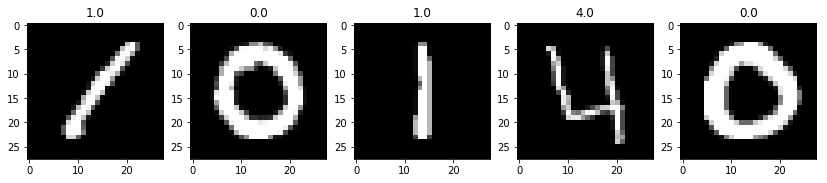

In [70]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [71]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [72]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

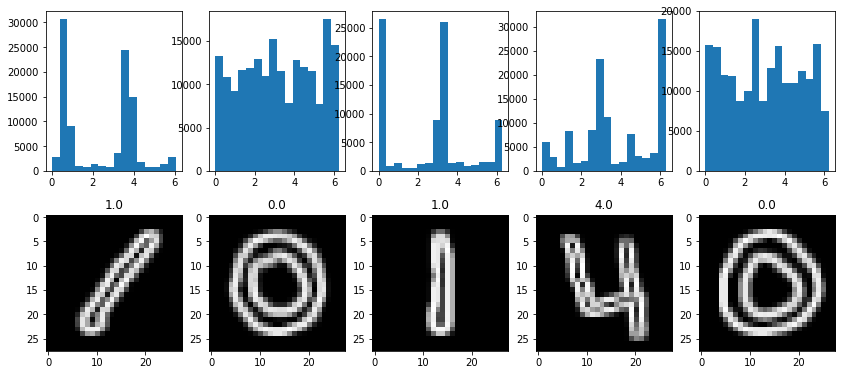

In [73]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [74]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [75]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [76]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [77]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [79]:
y_train.shape

(33600,)

In [80]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [95]:
checkpoint = keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5')
history = model.fit(x_train, y_train_labels, 
          batch_size=32, validation_split=0.25,
          epochs=10, verbose=0, callbacks = [checkpoint])

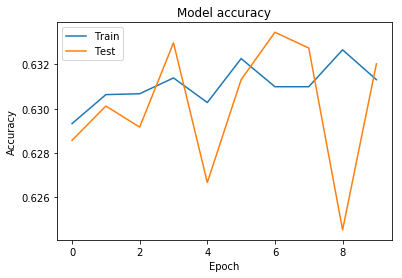

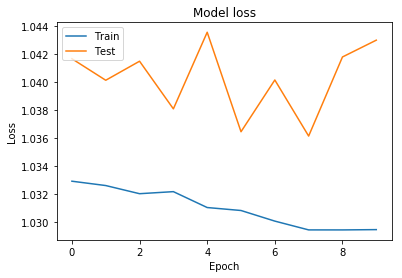

In [96]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Предсказываем класс объекта

In [84]:
pred_val = model.predict_classes(x_val)

In [85]:
pred_proba = model.predict_proba(x_val)

## Оцениваем качество решение на валидационной выборке

In [86]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6186904761904762


In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.38      0.29      0.33       816
         1.0       0.94      0.96      0.95       909
         2.0       0.46      0.34      0.39       846
         3.0       0.62      0.74      0.67       937
         4.0       0.71      0.67      0.69       839
         5.0       0.57      0.64      0.60       702
         6.0       0.43      0.46      0.44       785
         7.0       0.83      0.78      0.81       893
         8.0       0.48      0.60      0.53       835
         9.0       0.68      0.63      0.65       838

    accuracy                           0.62      8400
   macro avg       0.61      0.61      0.61      8400
weighted avg       0.62      0.62      0.61      8400



In [88]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[236  11  60  27  22  30 184   6 211  29]
 [  2 877   1   0  13   0   2   5   1   8]
 [ 54   0 291 168   7 150  54  19  91  12]
 [ 21   0  56 690   0  80   5   4  73   8]
 [ 17  29  13   3 562   1  99  33  10  72]
 [  7   1  60 128   1 447   9   6  39   4]
 [121   3  65  14  64  10 363  11  89  45]
 [  5   4  31   4  55  13  23 700   9  49]
 [106   0  23  66   7  51  45   7 505  25]
 [ 48   4  29  16  57   5  67  53  33 526]]


## Предсказания на тестовыйх данных

In [89]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

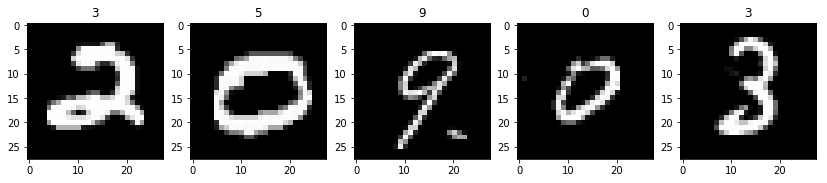

In [90]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [91]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843

# Keras tutorial

In [52]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 130s 2ms/step - loss: 0.2661 - acc: 0.9181 - val_loss: 0.0560 - val_acc: 0.9830
Epoch 2/12
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0884 - acc: 0.9738 - val_loss: 0.0451 - val_acc: 0.9852
Epoch 3/12
60000/60000 [==============================] - 163s 3ms/step - loss: 0.0650 - acc: 0.9806 - val_loss: 0.0353 - val_acc: 0.9876
Epoch 4/12
60000/60000 [==============================] - 162s 3ms/step - loss: 0.0521 - acc: 0.9845 - val_loss: 0.0304 - val_acc: 0.9899
Epoch 5/12
60000/60000 [==============================] - 153s 3ms/step - loss: 0.0451 - acc: 0.9868 - val_loss: 0.0287 - val_acc: 0.9907
Epoch 6/12
60000/60000 [==============================] - 162s 3ms/step 

In [ ]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

In [ ]:
from __future__ import print_function

from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
from PIL import Image

from six.moves import range

from keras.datasets import mnist
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np

np.random.seed(1337)
num_classes = 10


def build_generator(latent_size):
    # we will map a pair of (z, L), where z is a latent vector and L is a
    # label drawn from P_c, to image space (..., 28, 28, 1)
    cnn = Sequential()

    cnn.add(Dense(3 * 3 * 384, input_dim=latent_size, activation='relu'))
    cnn.add(Reshape((3, 3, 384)))

    # upsample to (7, 7, ...)
    cnn.add(Conv2DTranspose(192, 5, strides=1, padding='valid',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (14, 14, ...)
    cnn.add(Conv2DTranspose(96, 5, strides=2, padding='same',
                            activation='relu',
                            kernel_initializer='glorot_normal'))
    cnn.add(BatchNormalization())

    # upsample to (28, 28, ...)
    cnn.add(Conv2DTranspose(1, 5, strides=2, padding='same',
                            activation='tanh',
                            kernel_initializer='glorot_normal'))

    # this is the z space commonly referred to in GAN papers
    latent = Input(shape=(latent_size, ))

    # this will be our label
    image_class = Input(shape=(1,), dtype='int32')

    cls = Embedding(num_classes, latent_size,
                    embeddings_initializer='glorot_normal')(image_class)

    # hadamard product between z-space and a class conditional embedding
    h = layers.multiply([latent, cls])

    fake_image = cnn(h)

    return Model([latent, image_class], fake_image)


def build_discriminator():
    # build a relatively standard conv net, with LeakyReLUs as suggested in
    # the reference paper
    cnn = Sequential()

    cnn.add(Conv2D(32, 3, padding='same', strides=2,
                   input_shape=(28, 28, 1)))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(64, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(128, 3, padding='same', strides=2))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Conv2D(256, 3, padding='same', strides=1))
    cnn.add(LeakyReLU(0.2))
    cnn.add(Dropout(0.3))

    cnn.add(Flatten())

    image = Input(shape=(28, 28, 1))

    features = cnn(image)

    # first output (name=generation) is whether or not the discriminator
    # thinks the image that is being shown is fake, and the second output
    # (name=auxiliary) is the class that the discriminator thinks the image
    # belongs to.
    fake = Dense(1, activation='sigmoid', name='generation')(features)
    aux = Dense(num_classes, activation='softmax', name='auxiliary')(features)

    return Model(image, [fake, aux])


if __name__ == '__main__':
    # batch and latent size taken from the paper
    epochs = 100
    batch_size = 100
    latent_size = 100

    # Adam parameters suggested in https://arxiv.org/abs/1511.06434
    adam_lr = 0.0002
    adam_beta_1 = 0.5

    # build the discriminator
    print('Discriminator model:')
    discriminator = build_discriminator()
    discriminator.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    discriminator.summary()

    # build the generator
    generator = build_generator(latent_size)

    latent = Input(shape=(latent_size, ))
    image_class = Input(shape=(1,), dtype='int32')

    # get a fake image
    fake = generator([latent, image_class])

    # we only want to be able to train generation for the combined model
    discriminator.trainable = False
    fake, aux = discriminator(fake)
    combined = Model([latent, image_class], [fake, aux])

    print('Combined model:')
    combined.compile(
        optimizer=Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
    )
    combined.summary()

    # get our mnist data, and force it to be of shape (..., 28, 28, 1) with
    # range [-1, 1]
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)

    x_test = (x_test.astype(np.float32) - 127.5) / 127.5
    x_test = np.expand_dims(x_test, axis=-1)

    num_train, num_test = x_train.shape[0], x_test.shape[0]

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    for epoch in range(1, epochs + 1):
        print('Epoch {}/{}'.format(epoch, epochs))

        num_batches = int(np.ceil(x_train.shape[0] / float(batch_size)))
        progress_bar = Progbar(target=num_batches)

        epoch_gen_loss = []
        epoch_disc_loss = []

        for index in range(num_batches):
            # get a batch of real images
            image_batch = x_train[index * batch_size:(index + 1) * batch_size]
            label_batch = y_train[index * batch_size:(index + 1) * batch_size]

            # generate a new batch of noise
            noise = np.random.uniform(-1, 1, (len(image_batch), latent_size))

            # sample some labels from p_c
            sampled_labels = np.random.randint(0, num_classes, len(image_batch))

            # generate a batch of fake images, using the generated labels as a
            # conditioner. We reshape the sampled labels to be
            # (len(image_batch), 1) so that we can feed them into the embedding
            # layer as a length one sequence
            generated_images = generator.predict(
                [noise, sampled_labels.reshape((-1, 1))], verbose=0)

            x = np.concatenate((image_batch, generated_images))

            # use one-sided soft real/fake labels
            # Salimans et al., 2016
            # https://arxiv.org/pdf/1606.03498.pdf (Section 3.4)
            soft_zero, soft_one = 0, 0.95
            y = np.array(
                [soft_one] * len(image_batch) + [soft_zero] * len(image_batch))
            aux_y = np.concatenate((label_batch, sampled_labels), axis=0)

            # we don't want the discriminator to also maximize the classification
            # accuracy of the auxiliary classifier on generated images, so we
            # don't train discriminator to produce class labels for generated
            # images (see https://openreview.net/forum?id=rJXTf9Bxg).
            # To preserve sum of sample weights for the auxiliary classifier,
            # we assign sample weight of 2 to the real images.
            disc_sample_weight = [np.ones(2 * len(image_batch)),
                                  np.concatenate((np.ones(len(image_batch)) * 2,
                                                  np.zeros(len(image_batch))))]

            # see if the discriminator can figure itself out...
            epoch_disc_loss.append(discriminator.train_on_batch(
                x, [y, aux_y], sample_weight=disc_sample_weight))

            # make new noise. we generate 2 * batch size here such that we have
            # the generator optimize over an identical number of images as the
            # discriminator
            noise = np.random.uniform(-1, 1, (2 * len(image_batch), latent_size))
            sampled_labels = np.random.randint(0, num_classes, 2 * len(image_batch))

            # we want to train the generator to trick the discriminator
            # For the generator, we want all the {fake, not-fake} labels to say
            # not-fake
            trick = np.ones(2 * len(image_batch)) * soft_one

            epoch_gen_loss.append(combined.train_on_batch(
                [noise, sampled_labels.reshape((-1, 1))],
                [trick, sampled_labels]))

            progress_bar.update(index + 1)

        print('Testing for epoch {}:'.format(epoch))

        # evaluate the testing loss here

        # generate a new batch of noise
        noise = np.random.uniform(-1, 1, (num_test, latent_size))

        # sample some labels from p_c and generate images from them
        sampled_labels = np.random.randint(0, num_classes, num_test)
        generated_images = generator.predict(
            [noise, sampled_labels.reshape((-1, 1))], verbose=False)

        x = np.concatenate((x_test, generated_images))
        y = np.array([1] * num_test + [0] * num_test)
        aux_y = np.concatenate((y_test, sampled_labels), axis=0)

        # see if the discriminator can figure itself out...
        discriminator_test_loss = discriminator.evaluate(
            x, [y, aux_y], verbose=False)

        discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)

        # make new noise
        noise = np.random.uniform(-1, 1, (2 * num_test, latent_size))
        sampled_labels = np.random.randint(0, num_classes, 2 * num_test)

        trick = np.ones(2 * num_test)

        generator_test_loss = combined.evaluate(
            [noise, sampled_labels.reshape((-1, 1))],
            [trick, sampled_labels], verbose=False)

        generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)

        # generate an epoch report on performance
        train_history['generator'].append(generator_train_loss)
        train_history['discriminator'].append(discriminator_train_loss)

        test_history['generator'].append(generator_test_loss)
        test_history['discriminator'].append(discriminator_test_loss)

        print('{0:<22s} | {1:4s} | {2:15s} | {3:5s}'.format(
            'component', *discriminator.metrics_names))
        print('-' * 65)

        ROW_FMT = '{0:<22s} | {1:<4.2f} | {2:<15.4f} | {3:<5.4f}'
        print(ROW_FMT.format('generator (train)',
                             *train_history['generator'][-1]))
        print(ROW_FMT.format('generator (test)',
                             *test_history['generator'][-1]))
        print(ROW_FMT.format('discriminator (train)',
                             *train_history['discriminator'][-1]))
        print(ROW_FMT.format('discriminator (test)',
                             *test_history['discriminator'][-1]))

        # save weights every epoch
        generator.save_weights(
            'params_generator_epoch_{0:03d}.hdf5'.format(epoch), True)
        discriminator.save_weights(
            'params_discriminator_epoch_{0:03d}.hdf5'.format(epoch), True)

        # generate some digits to display
        num_rows = 40
        noise = np.tile(np.random.uniform(-1, 1, (num_rows, latent_size)),
                        (num_classes, 1))

        sampled_labels = np.array([
            [i] * num_rows for i in range(num_classes)
        ]).reshape(-1, 1)

        # get a batch to display
        generated_images = generator.predict(
            [noise, sampled_labels], verbose=0)

        # prepare real images sorted by class label
        real_labels = y_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes]
        indices = np.argsort(real_labels, axis=0)
        real_images = x_train[(epoch - 1) * num_rows * num_classes:
                              epoch * num_rows * num_classes][indices]

        # display generated images, white separator, real images
        img = np.concatenate(
            (generated_images,
             np.repeat(np.ones_like(x_train[:1]), num_rows, axis=0),
             real_images))

        # arrange them into a grid
        img = (np.concatenate([r.reshape(-1, 28)
                               for r in np.split(img, 2 * num_classes + 1)
                               ], axis=-1) * 127.5 + 127.5).astype(np.uint8)

        Image.fromarray(img).save(
            'plot_epoch_{0:03d}_generated.png'.format(epoch))

    with open('acgan-history.pkl', 'wb') as f:
        pickle.dump({'train': train_history, 'test': test_history}, f)